In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import tqdm


import warnings
warnings.filterwarnings("ignore")

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%time
train = pd.read_csv('data/new_train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('data/new_test.csv', parse_dates=['first_active_month'])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [3]:
with open('data/use_to_col.txt', 'r') as fin:
    use_to_col = [i for i in fin.read().split(',') if i]

In [4]:
drop_train = ['binned_num_hist_transactions', 'binned_sum_hist_trans', 'binned_num_merch_transactions',
             'binned_sum_merch_trans', 'binned_mean_merch_trans']

In [5]:
train.drop(columns=drop_train, inplace=True)

In [6]:
for i in range(1, 4):
    train['feature_' + str(i)] = train['feature_' + str(i)].astype('category')
    
for i in range(1, 4):
    test['feature_' + str(i)] = test['feature_' + str(i)].astype('category')

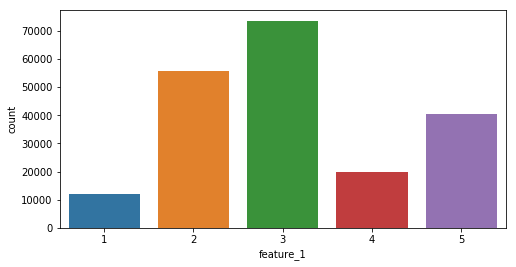

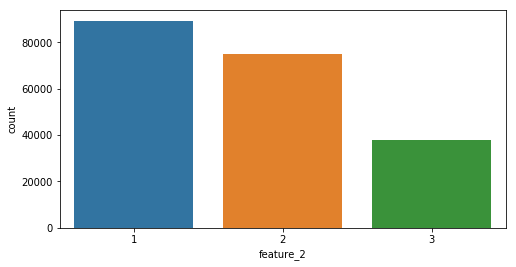

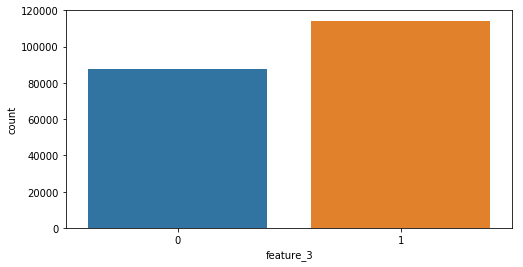

In [16]:
for i in range(1, 4):
    plt.figure(figsize=(8, 4))
    sns.countplot(train['feature_' + str(i)])
    plt.show()

In [8]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = \
test.loc[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1), \
         'first_active_month'].min()

In [11]:
max_date = train['first_active_month'].dt.date.max()

def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [12]:
train = process_main(train)
test = process_main(test)

In [14]:
train.drop(columns=['year', 'month'], inplace=True)
test.drop(columns=['year', 'month'], inplace=True)

In [15]:
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transaction,sum_hist_trans,mean_hist_trans,std_hist_trans,...,num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,-165.968739,-0.638341,0.212139,...,23.0,-13.244202,-0.575835,0.135812,-0.724368,-0.296112,2017,3,6,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,-210.006336,-0.600018,0.384967,...,6.0,-4.355735,-0.725956,0.014326,-0.739410,-0.701858,2017,6,1,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,-29.167391,-0.678311,0.087380,...,1.0,-0.700326,-0.700326,NaN,-0.700326,-0.700326,2016,0,8,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,-49.491364,-0.642745,0.261624,...,7.0,-4.654372,-0.664910,0.065882,-0.734135,-0.566740,2017,4,9,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,-48.687656,-0.366073,1.352094,...,36.0,-19.926237,-0.553507,0.223821,-0.739395,0.450886,2017,2,11,92


In [17]:
historical_transaction = pd.read_csv('data/historical_transactions.csv')
historical_transaction.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [27]:
historical_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         int64
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(7), object(5)
memory usage: 3.0+ GB


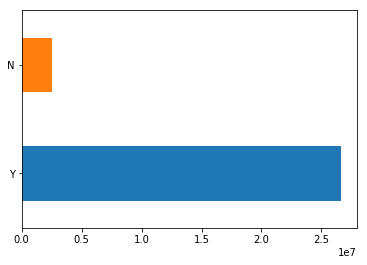

In [22]:
historical_transaction['authorized_flag'].value_counts().plot(kind='barh')
plt.show()

In [23]:
historical_transaction['authorized_flag'] = historical_transaction['authorized_flag'].apply(lambda x: 1 if x == 'Y' \
                                                                                           else 0)

In [26]:
autorized_card_rate = historical_transaction.groupby(['card_id'])['authorized_flag'].mean().sort_values()
display(autorized_card_rate.head(5))
print()
display(autorized_card_rate.tail())

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

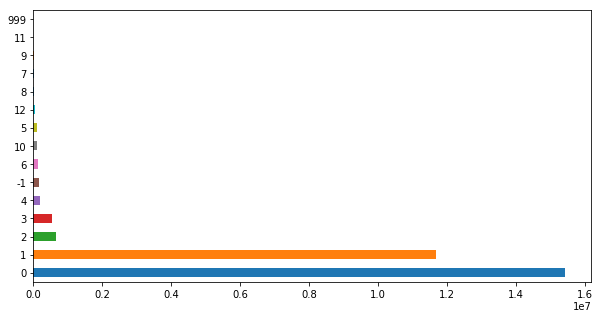

15


In [32]:
plt.figure(figsize=(10, 5))
historical_transaction['installments'].value_counts().plot(kind='barh')
plt.show()

print(historical_transaction['installments'].value_counts().count())

In [33]:
historical_transaction['installments'] = historical_transaction['installments'].astype('category')

In [38]:
historical_transaction['purchase_date'] = pd.to_datetime(historical_transaction['purchase_date'])

In [45]:
map_dict = {'Y': 0, 'N': 1}

historical_transaction['category_1'] = historical_transaction['category_1'].apply(lambda x: map_dict[x])
display(historical_transaction.groupby(['category_1'])['purchase_amount'].agg(['mean', 'std', 'count']).reset_index())
display(historical_transaction.groupby(['category_1'])['authorized_flag'].agg(['mean', 'std']).reset_index())


,category_1,mean,std,count
0,0,-0.419327,22.087594,2084029
1,1,0.071540,1166.016045,27028332


,category_1,mean,std
0,0,0.748578,0.433830
1,1,0.926265,0.261339


In [48]:
display(historical_transaction.groupby(['category_2'])['purchase_amount'].agg(['mean', 'std', 'count']).reset_index())
display(historical_transaction.groupby(['category_2'])['authorized_flag'].agg(['mean', 'std']).reset_index())

,category_2,mean,std,count
0,1.0,0.149570,1548.714128,15177199
1,2.0,-0.165690,89.285770,1026535
2,3.0,0.180375,210.616100,3911795
3,4.0,-0.158951,141.945606,2618053
4,5.0,-0.104457,162.428785,3725915


,category_2,mean,std
0,1.0,0.927505,0.259306
1,2.0,0.906225,0.291515
2,3.0,0.918857,0.273055
3,4.0,0.927634,0.259094
4,5.0,0.934260,0.247826


In [50]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
historical_transaction['category_3'] = historical_transaction['category_3'].apply(lambda x: map_dict[str(x)])
historical_transaction.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 
                                                    'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_3                                                                 
0                 0.361926  1541.485188  15411747        0.928032  0.258436
1                -0.404556   104.062692  11677522        0.907024  0.290399
2                 0.106023    24.047655   1844933        0.836498  0.369824
3                 0.058447     2.191567    178159        0.885692  0.318186

In [51]:
def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
#     trans['year'] = trans['purchase_date'].dt.year
#     trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
#     trans['month'] = trans['purchase_date'].dt.month
#     trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
#     trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
#     trans['hour'] = trans['purchase_date'].dt.hour
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans['installments'] = trans['installments'].astype(int)

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']). \
                                        astype(np.int64) * 1e-9
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
        'month_diff': ['min', 'max', 'mean']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [53]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(historical_transaction) 

In [56]:
display(final_group.head(5))
print(final_group.shape)

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,11.461538,4.701336,-5.911157,2.767303,-0.507947,0.097299,-0.704152,...,14.769231,6.431094,1.348480,0.357031,1.000000,0.000000,2.615385,1.556624,0.625616,0.609378
1,C_ID_0001238066,-2.500000,1.870829,20.500000,12.275993,-12.074534,7.033955,-0.603204,0.045861,-0.730351,...,33.000000,25.226970,1.639345,0.395889,0.666667,0.816497,4.666667,2.875181,1.246996,0.507930
2,C_ID_0001506ef0,-6.230769,4.225988,5.076923,4.536179,-2.661683,3.008707,-0.461749,0.259737,-0.725724,...,0.076923,0.277350,0.012821,0.046225,0.000000,0.000000,0.076923,0.277350,0.034021,0.117851
3,C_ID_0001793786,-4.500000,3.027650,21.600000,13.969809,-3.678601,4.769788,-0.042211,0.277565,-0.647028,...,0.500000,0.849837,0.014621,0.024394,0.000000,0.000000,0.300000,0.483046,0.065065,0.105721
4,C_ID_000183fdda,-3.000000,2.160247,20.571429,9.198861,-9.833991,6.162143,-0.425378,0.214361,-0.687901,...,37.714286,15.445758,1.998522,0.553938,0.428571,0.975900,8.714286,2.214670,2.173750,0.618504


(325540, 27)


In [63]:
history = aggregate_historical_transactions(historical_transaction, prefix='hist_')

In [64]:
history.head(5)

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,...,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean
0,C_ID_00007093c1,149,114,0.765101,121,0.812081,0.000000,0.0,0.000000,0.0,...,1.487081e+09,-12,0,18,3,13,4,9,11,9.946309
1,C_ID_0001238066,123,120,0.975610,121,0.983740,0.772358,95.0,0.000000,0.0,...,1.506638e+09,-5,0,29,6,17,18,9,10,9.943089
2,C_ID_0001506ef0,66,62,0.939394,66,1.000000,0.030303,2.0,0.000000,0.0,...,1.484411e+09,-13,0,19,2,12,3,9,11,10.000000
3,C_ID_0001793786,216,189,0.875000,214,0.990741,0.050926,11.0,0.351852,76.0,...,1.484994e+09,-9,0,48,4,24,10,13,15,13.976852
4,C_ID_000183fdda,144,137,0.951389,140,0.972222,0.048611,7.0,0.006944,1.0,...,1.502099e+09,-6,0,36,7,21,9,9,10,9.888889


In [65]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [66]:
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transaction,sum_hist_trans,mean_hist_trans,std_hist_trans,...,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,-165.968739,-0.638341,0.212139,...,1.498573e+09,-8,0,41,3,21,7,9,11,9.934615
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,-210.006336,-0.600018,0.384967,...,1.483720e+09,-12,0,57,3,24,9,10,12,10.945714
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,-29.167391,-0.678311,0.087380,...,1.484123e+09,-13,0,8,2,7,5,9,10,9.953488
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,-49.491364,-0.642745,0.261624,...,1.506443e+09,-5,0,25,5,13,7,9,10,9.883117
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,-48.687656,-0.366073,1.352094,...,1.510445e+09,-3,0,26,6,17,6,9,10,9.872180


In [91]:
new_merchant_transactions = pd.read_csv('data/new_merchant_transactions.csv')
display(new_merchant_transactions.head(5))
display(new_merchant_transactions.info())
print(new_merchant_transactions.shape)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


None

(1963031, 14)


In [92]:
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].apply(lambda x: 1 if
                                                                                                  x == 'Y' 
                                                                                                  else 0)

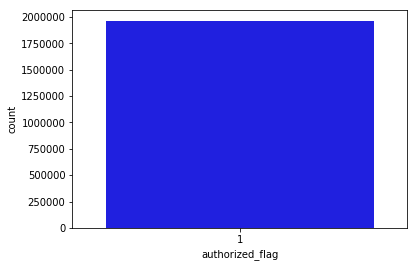

In [78]:
sns.countplot(new_merchant_transactions['authorized_flag'], orient='h', color='b')
plt.show()

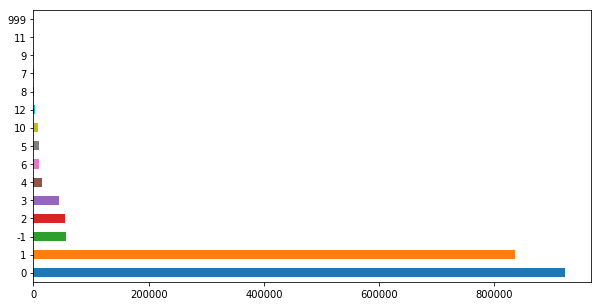

In [80]:
plt.figure(figsize=(10, 5))
new_merchant_transactions['installments'].value_counts().plot(kind='barh')
plt.show()

In [93]:
new_merchant_transactions['installments'] = new_merchant_transactions['installments'].astype('category')

In [94]:
new_merchant_transactions['purchase_date'] = pd.to_datetime(new_merchant_transactions['purchase_date'])

In [95]:
map_dict = {'Y': 0, 'N': 1}
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].apply(lambda x: map_dict[x])
new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_1                                   
0                -0.218671  1.481696    63096
1                -0.562004  0.648799  1899935

In [96]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].apply(lambda x: map_dict[str(x)])
new_merchant_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                  
                      mean       std   count
category_3                                  
0                -0.631014  0.268039  922244
1                -0.606486  0.443664  836178
2                 0.037708  1.787946  148687
3                 0.034033  1.692377   55922

In [97]:
def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['year'] = trans['purchase_date'].dt.year
    trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
    trans['month'] = trans['purchase_date'].dt.month
    trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
    trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
    trans['hour'] = trans['purchase_date'].dt.hour
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [98]:
history = aggregate_historical_transactions(new_merchant_transactions, prefix='new')

train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [99]:
train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 139 entries, first_active_month to installments_std_std
dtypes: category(3), datetime64[ns](1), float64(111), int64(22), object(1), uint8(1)
memory usage: 210.3+ MB


In [108]:
merchants = pd.read_csv('data/merchants.csv')

display(merchants.head(5))
display(merchants.info())
print(merchants.shape)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

None

(334696, 22)


In [110]:
map_dict = {'Y': 0, 'N': 1}
merchants['category_1'] = merchants['category_1'].apply(lambda x: map_dict[x])
merchants.loc[merchants['category_2'].isnull(), 'category_2'] = 0
merchants['category_4'] = merchants['category_4'].apply(lambda x: map_dict[x])

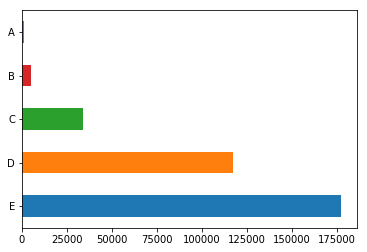

In [112]:
merchants['most_recent_sales_range'].value_counts().plot(kind='barh')
plt.show()

In [113]:
merchants['avg_purchases_lag3'].nlargest()

10                inf
11                inf
12                inf
235      6.185133e+04
13168    1.730000e+03
Name: avg_purchases_lag3, dtype: float64

In [114]:
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000

In [115]:
for col in train.columns:
    if train[col].isna().any():
        train[col] = train[col].fillna(0)

In [116]:
for col in test.columns:
    if test[col].isna().any():
        test[col] = test[col].fillna(0)

In [117]:
y = train['target']

col_to_drop = ['first_active_month', 'card_id', 'target']

In [118]:
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [120]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

In [121]:
categorical_feats = ['feature_1', 'feature_2']

for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [122]:
train.head(5) # !!!!!!!!!! другая кодировка кат фичей

,feature_1,feature_2,feature_3,num_hist_transaction,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,num_merch_transactions,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,4,1,1,260,-165.968739,-0.638341,0.212139,-0.739395,2.258395,23.0,...,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067
1,3,0,0,350,-210.006336,-0.600018,0.384967,-0.742400,4.630299,6.0,...,41.769231,14.341977,1.713279,0.546685,0.692308,0.751068,6.307692,2.780426,1.478938,0.895708
2,1,1,0,43,-29.167391,-0.678311,0.087380,-0.730138,-0.145847,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,2,0,77,-49.491364,-0.642745,0.261624,-0.740897,1.445596,7.0,...,14.000000,11.523888,1.044819,0.215637,0.333333,1.032796,2.000000,1.095445,0.518905,0.483284
4,0,2,0,133,-48.687656,-0.366073,1.352094,-0.746156,7.193041,36.0,...,45.500000,23.979158,1.369969,0.597277,1.000000,0.000000,4.500000,5.066228,1.083005,1.664428


In [123]:
for col in ['newpurchase_amount_max', 'newpurchase_date_max', 'purchase_amount_max_mean']:
    train[col + '_to_mean'] = train[col] / train[col].mean()
    test[col + '_to_mean'] = test[col] / test[col].mean()

## models

In [124]:
X = train
X_test = test

In [153]:
n_fold = 5
folds = KFold(n_splits=n_folds, shuffle=True, random_state=11)

In [154]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb',
                plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print(f'Fold {fold_n}. RMSE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",
                                                                                    ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [128]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}

Fold 0 started at Sun Dec 23 18:41:23 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[762]	training's rmse: 3.37624	valid_1's rmse: 3.70111
Fold 1 started at Sun Dec 23 18:41:58 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[790]	training's rmse: 3.38306	valid_1's rmse: 3.63727
Fold 2 started at Sun Dec 23 18:42:32 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[724]	training's rmse: 3.3918	valid_1's rmse: 3.672
Fold 3 started at Sun Dec 23 18:43:03 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[589]	training's rmse: 3.42212	valid_1's rmse: 3.66262
Fold 4 started at Sun Dec 23 18:43:30 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[503]	training's rmse: 3.45917	valid_1's rmse: 3.61455
CV mean score: 3.6575, 

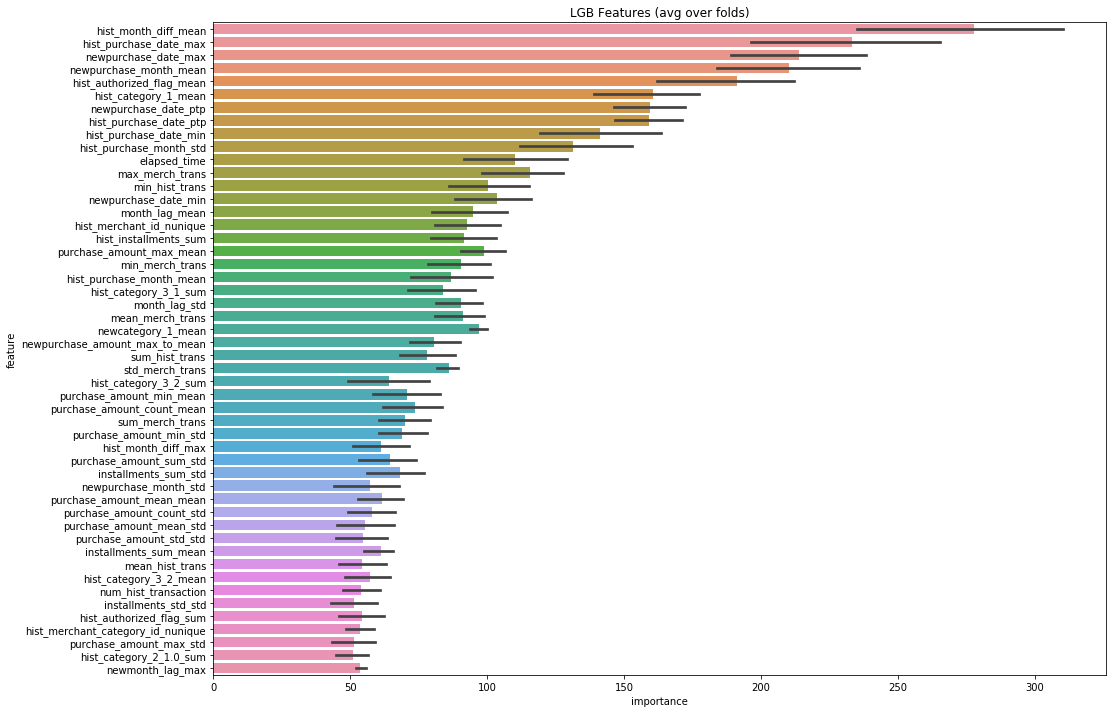

In [155]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', 
                                                          plot_feature_importance=True)

In [156]:
submission = pd.read_csv('data/sample_submission.csv')

In [159]:
submission['target'] = prediction_lgb
submission.to_csv('lgb.csv', index=False)

In [160]:
xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Sun Dec 23 18:47:36 2018
[0]	train-rmse:3.92626	valid_data-rmse:4.01763
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.72209	valid_data-rmse:3.70926
Stopping. Best iteration:
[548]	train-rmse:2.6814	valid_data-rmse:3.70878

Fold 1 started at Sun Dec 23 18:55:46 2018
[0]	train-rmse:3.95176	valid_data-rmse:3.91727
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.73464	valid_data-rmse:3.64051
Stopping. Best iteration:
[426]	train-rmse:2.80111	valid_data-rmse:3.64023

Fold 2 started at Sun Dec 23 19:03:05 2018
[0]	train-rmse:3.9344	valid_data-rmse:3.98879
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

In [161]:
submission['target'] = prediction_xgb
submission.to_csv('xgb.csv', index=False)

In [162]:
oof_rcv, prediction_rcv = train_model(params=None, model_type='rcv')

Fold 0 started at Sun Dec 23 23:52:46 2018
100.0
Fold 0. RMSE: 3.8339.

Fold 1 started at Sun Dec 23 23:53:19 2018
100.0
Fold 1. RMSE: 20.5430.

Fold 2 started at Sun Dec 23 23:53:46 2018
100.0
Fold 2. RMSE: 3.8102.

Fold 3 started at Sun Dec 23 23:54:17 2018
0.1
Fold 3. RMSE: 3.7740.

Fold 4 started at Sun Dec 23 23:54:43 2018
0.1
Fold 4. RMSE: 3.7276.

CV mean score: 7.1377, std: 6.7027.


In [163]:
submission['target'] = prediction_rcv
submission.to_csv('rcv.csv', index=False)

In [164]:
cat_params = {'learning_rate': 0.01,
              'depth': 9,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(params=cat_params, model_type='cat')

Fold 0 started at Sun Dec 23 23:56:18 2018
Fold 1 started at Sun Dec 23 23:58:19 2018
Fold 2 started at Mon Dec 24 00:00:38 2018
Fold 3 started at Mon Dec 24 00:03:16 2018
Fold 4 started at Mon Dec 24 00:04:25 2018
CV mean score: 3.6612, std: 0.0288.


In [165]:
submission['target'] = (prediction_lgb + prediction_cat + prediction_rcv + prediction_xgb) / 4
submission.to_csv('blend.csv', index=False)

In [176]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_rcv, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack)
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_rcv, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

In [179]:
oof_lgb_stack, prediction_lgb_stack = train_model(X=train_stack, X_test=test_stack,
                                                  params=params, model_type='lgb')

Fold 0 started at Mon Dec 24 00:11:28 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[183]	training's rmse: 3.60856	valid_1's rmse: 3.70714
Fold 1 started at Mon Dec 24 00:11:31 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[121]	training's rmse: 3.6337	valid_1's rmse: 3.64073
Fold 2 started at Mon Dec 24 00:11:34 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[163]	training's rmse: 3.62048	valid_1's rmse: 3.67762
Fold 3 started at Mon Dec 24 00:11:36 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[102]	training's rmse: 3.63543	valid_1's rmse: 3.66321
Fold 4 started at Mon Dec 24 00:11:39 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[161]	training's rmse: 3.63545	valid_1's rmse: 3.6194
CV mean score: 3.6616,

In [182]:
submission['target'] = prediction_lgb_stack
submission.to_csv('stacker_lgb.csv', index=False)

In [183]:
oof_rcv_stack, prediction_rcv_stack = train_model(X=train_stack, X_test=test_stack, 
                                                  params=None, model_type='rcv')

Fold 0 started at Mon Dec 24 00:12:46 2018
0.1
Fold 0. RMSE: 3.6973.

Fold 1 started at Mon Dec 24 00:12:47 2018
100.0
Fold 1. RMSE: 3.6496.

Fold 2 started at Mon Dec 24 00:12:47 2018
0.1
Fold 2. RMSE: 3.6709.

Fold 3 started at Mon Dec 24 00:12:47 2018
100.0
Fold 3. RMSE: 3.6631.

Fold 4 started at Mon Dec 24 00:12:48 2018
100.0
Fold 4. RMSE: 3.6150.

CV mean score: 3.6592, std: 0.0270.


In [184]:
submission['target'] = prediction_rcv_stack
submission.to_csv('stacker_rcv.csv', index=False)

In [185]:
train.to_csv('up_train.csv', index=False)
y.to_csv('up_y.csv', index=False)

test.to_csv('up_test.csv', index=False)